In [1]:
using LinearAlgebra
import Pkg
#Pkg.add("Plots")
using Plots
#Pkg.add("LaTeXStrings")
using LaTeXStrings

In [2]:
using Fermions
using LinearAlgebra
using Fermions.Aux
using Fermions.Models
using Plots
using LaTeXStrings

In [3]:
nsites = 3
function Hubbard(space::FockSpace, U::Real, t::Real, μ::Real)
    H = Operator(space)
    c = annihilators(space)
    dim = space.nflavours
    if dim == 4
        for i in 1:2
            H += t * c[i+2]'*c[i]
            H += t * c[i]'*c[i+2]
            H -= μ * c[i]' * c[i]
            H -= μ * c[i+2]' * c[i+2]
        end
    else
        for i in 1:dim
            if i >= dim-1
                H += t * c[i]'*c[i-dim+2]
                H += t * c[i-dim+2]'*c[i']
            else
                H += t * c[i+2]'*c[i] #electron hopping
                H += t * c[i]'*c[i+2]
            end
            H -= μ * c[i]' * c[i] #chemical potential
        end
    end
    for i in 1:Int(dim/2)
        H += U * c[2*i-1]'*c[2*i-1]*c[2*i]'*c[2*i] #Coulomb repulsion
    end
    return H
end

Hubbard (generic function with 1 method)

In [4]:
space = FockSpace(2 * nsites)

FockSpace{UInt64}(6, 0x000000000000003f)

To express the Hamiltonian above, we need the annihilation operators
$c_{i\sigma}$. `annihilators` returns an array of these objects. Now,
to add a spin dimension, we simply reshape that array so that the second index corresponds to a spin index.

In [5]:
c = reshape(annihilators(space), (nsites, 2))

3×2 Matrix{Operator{Int8, Tuple{Term{Int8, UInt64}}, FockSpace{UInt64}}}:
 1 c[1]  1 c[4]
 1 c[2]  1 c[5]
 1 c[3]  1 c[6]

The creation operator is simply given by conjugate transpose, e.g., `c[1,1]'`.  A normal ordered product (`Term`) can now be formed by simply multiplying operators:

Creating the Hamiltonian now involves a sum of terms.  For this,
we create a `Operator` instance and simply add terms to it:

In [6]:
H = Hubbard(space,3.,-1.,1.5)

t = 1.0
u = 3.0
H = Operator(space)
for i in 1:nsites
    H += u * c[i,1]' * c[i,2]' * c[i,2] * c[i,1]

    j = i % nsites + 1
    for σ in 1:2
        H += -t * c[j,σ]' * c[i,σ]
        H += -t * c[i,σ]' * c[j,σ]
    end
end
H

Operator{Float64, Vector{Term{Float64, UInt64}}, FockSpace{UInt64}} for 6 flavours (15 terms):
-1.0 c[4]' c[6]
-1.0 c[5]' c[6]
-1.0 c[4]' c[5]
-1.0 c[1]' c[3]
-1.0 c[2]' c[3]
-1.0 c[1]' c[2]
3.0 n[1] n[4]
3.0 n[2] n[5]
3.0 n[3] n[6]
-1.0 c[2]' c[1]
-1.0 c[3]' c[2]
-1.0 c[3]' c[1]
-1.0 c[5]' c[4]
-1.0 c[6]' c[5]
-1.0 c[6]' c[4]

In [7]:
ishermitian(H)

true

Using symmetries
----------------

Even with on-the-fly evaluation, the Fock space will grow too quickly,
which bars us from constructing the vectors.  However, we can remedy
that using symmetries.

The Hamiltonian conserves the total number of particles $N$ as well
as the total spin in $z$-direction $S_{z,tot}$.  We construct a
set of quantum numbers for those:

In [8]:
quantum_numbers = NSzSet(space)

NSet{2}(FockSpace{UInt64}(6, 0x000000000000003f), 3, 3)

In [9]:
conserves(quantum_numbers, H)

true

This partitions the Fock space into a set of blocks

**Block operator**

We can also construct just one block for some values of quantum numbers.
For example, the following gets only the block with a filling close to
half in each spin.

In [10]:
using Fermions.Propagators
#Pkg.add("SparseIR")
using SparseIR

In [11]:
beta = 10

10

In [12]:
ham_eb = Fermions.Propagators.HamiltonianEigen(H, quantum_numbers, beta)


HamiltonianEigen{Operator{Float64, Vector{Term{Float64, UInt64}}, FockSpace{UInt64}}, NSet{2}, Tuple{Int64, Int64}, Fermions.NSetBlock{2}, Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}}(-1.0 c[4]' c[6]
-1.0 c[5]' c[6]
-1.0 c[4]' c[5]
-1.0 c[1]' c[3]
-1.0 c[2]' c[3]
-1.0 c[1]' c[2]
3.0 n[1] n[4]
3.0 n[2] n[5]
3.0 n[3] n[6]
-1.0 c[2]' c[1]
-1.0 c[3]' c[2]
-1.0 c[3]' c[1]
-1.0 c[5]' c[4]
-1.0 c[6]' c[5]
-1.0 c[6]' c[4], NSet{2}(FockSpace{UInt64}(6, 0x000000000000003f), 3, 3), Dict{Tuple{Int64, Int64}, Fermions.NSetBlock{2}}((1, 2) => Fermions.NSetBlock{2}(nflv=6, Ntot=1, Ntot=2), (3, 1) => Fermions.NSetBlock{2}(nflv=6, Ntot=3, Ntot=1), (0, 2) => Fermions.NSetBlock{2}(nflv=6, Ntot=0, Ntot=2), (1, 3) => Fermions.NSetBlock{2}(nflv=6, Ntot=1, Ntot=3), (2, 2) => Fermions.NSetBlock{2}(nflv=6, Ntot=2, Ntot=2), (0, 3) => Fermions.NSetBlock{2}(nflv=6, Ntot=0, Ntot=3), (2, 3) => Fermions.NSetBlock{2}(nflv=6, Ntot=2, Ntot=3), (1, 0) => Fermions.NSetBlock{2}(nflv=6, Ntot=1, Ntot=0), (0, 0

We can use the `full_tau` function of the Propagators module: it expects the operators and a tau grid to use:

The Fourier transform is available using the `full_freq` function:
$$
    \hat G(i\omega_n) = \int_0^\beta \exp(i\omega_n\tau) G(\tau) d\tau
$$
The Matsubara frequencies have to be specified as `FermionicFreq` or
`BosonicFreq` objects, where the argument is the prefactor to $i\pi/\beta$, i.e., odd numbers for fermionic frequencies and even numbers for bosonic
frequencies.

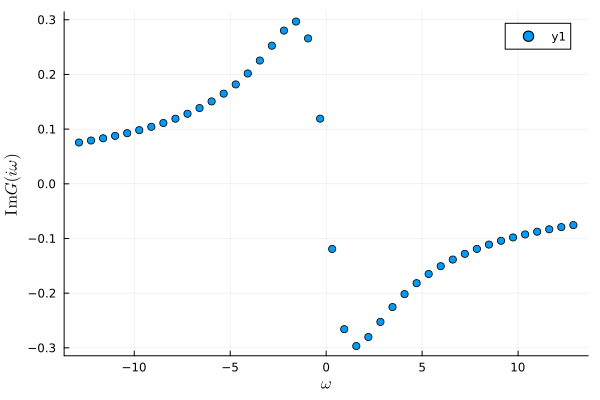

In [13]:
#import Pkg
#Pkg.add("Plots")
using Plots

A = -c[1, 1]
B = c[1, 1]'

wn = FermionicFreq(-41):FermionicFreq(41)
w = SparseIR.value.(wn, beta);

giw = full_freq((A, B), wn, ham_eb, beta)

Plots.scatter(w, imag.(giw), xlabel=L"\omega", ylabel=L"\mathrm{Im} G(i\omega)")

In [14]:
#import Pkg
#Pkg.add("CSV")
#Pkg.add("DataFrames")
using CSV
using DataFrames

data = CSV.read("data.csv", DataFrame, delim=" ",ignorerepeated=true, header=false) 

LoadError: ArgumentError: "data.csv" is not a valid file or doesn't exist

In [15]:
giw_origin_im = data[!,7]
#giw_origin_re = data[!,6]
w_origin = data[!,5]
plt=Plots.scatter(w_origin, giw_origin_im, xlabel=L"\omega", ylabel=L"\mathrm{Im} G(i\omega)")
#plt=Plots.scatter(w_origin, giw_origin_re, xlabel=L"\omega", ylabel=L"\mathrm{Re} G(i\omega)")
Plots.scatter!(plt,w, imag.(giw), xlabel=L"\omega", ylabel=L"\mathrm{Im} G(i\omega)")

LoadError: UndefVarError: data not defined

Multi-point Green's function
----------------------------

To compute Greens functions of the form:
$$
    G_{ABC}(\tau') = \langle T A(\tau) B(\tau') C(0) \rangle
$$
from the Lehmann representation, we can use the same function,
but we need to specify three operators and a list of tuples
$(\tau,\tau')$.

In [33]:
# split the area into two simplices

using SimplexQuad

function G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1, ω2, τ_arr1, τ_arr2, weights, ham_eb)
    
    f_vector = Array{typeof(zero(ComplexF64)), 1}(undef,length(τ_arr1))
    
    for f in 1:length(f_vector) 
        f_vector[f] = 0
    end
    
    tautau = []
    for f in 1:length(f_vector)
        τ_1= τ_arr1[f]
        τ_2= τ_arr2[f]
        #tautau = collect(Iterators.product( τ_1*β,τ_2*β))
        push!(tautau, (τ_1*β,τ_2*β))
    end
    
    matrix2 = full_tau((A,B,C), tautau, ham_eb, β) 
    
    for f in 1:length(f_vector) 
        τ_1= τ_arr1[f]
        τ_2= τ_arr2[f]

        f_vector[f] = ℯ.^(im*ω1*τ_1*β)* matrix2[f] * ℯ.^(im*ω2*τ_2*β)
    end
    
    return dot(weights*β*β,f_vector)  
end

function G_ABC_gl_transform_simplex(A, B, C, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+0)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+0)*π/β
    
    X, W = simplexquad(50, 2)
    #X, W = simplexquad(10, 2)
    Y=1 .-X
    
    
    quantum_numbers = NullSet(space)
    ham_eb = Fermions.Propagators.HamiltonianEigen(H, quantum_numbers, β)
    
    result = Array{typeof(zero(ComplexF64)), 2}(undef,length(ω1),length(ω2)) 
    for j in 1:length(ω1)
        for k in 1:length(ω2)    

            values1 = G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], 1 .-X[:,1],X[:,2],W, ham_eb)
            values2 = G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], 1 .-Y[:,1],Y[:,2],W, ham_eb)
            integral = values1+values2

            result[j,k] = integral
        end
    end
    #result = integral
    return result
end


G_ABC_gl_transform_simplex (generic function with 1 method)

In [17]:
wn = BosonicFreq(-30):BosonicFreq(30)
ww = collect(Iterators.product(wn, wn))
w = SparseIR.value.(wn, beta);

A1 = c[1, 1]' * c[1, 1]
B1 = c[1, 1]' * c[1, 1]
C1 = c[1, 1]' * c[1, 1]

tau = 0:0.1:beta
tautau = collect(Iterators.product( tau,tau))

@time R1_tau = full_tau((A1,B1,C1), tautau, ham_eb, beta)

""
#plot(tau,tau,real.(R1_tau), st=:surface)

  3.017640 seconds (7.55 M allocations: 357.641 MiB, 6.27% gc time, 99.02% compilation time)


""

In [18]:
@time R1_omega = G_ABC_gl_transform_simplex(A1, B1, C1, H, beta, space, 11, 11)


  9.143211 seconds (16.82 M allocations: 1017.838 MiB, 6.07% gc time, 74.72% compilation time)


23×23 Matrix{ComplexF64}:
    0.17033+2.498e-15im    …   -0.210198+3.88578e-16im
   0.314946+3.19189e-15im     -0.0670435-6.245e-16im
   0.184306+1.05471e-15im      -0.245154+1.09981e-15im
   0.215864+1.63758e-15im      -0.219203+6.80012e-16im
   0.172223+1.85962e-15im      -0.248474+1.5335e-15im
   0.150999+6.93889e-16im  …   -0.275255+2.07473e-15im
   0.162571+7.07767e-16im      -0.307782+1.59595e-15im
   0.263508+2.04003e-15im      -0.347466+1.84575e-15im
   0.497603+2.7478e-15im       -0.410151+1.66533e-15im
   0.813593+5.20417e-15im      -0.417343+2.47025e-15im
   0.963717+6.05072e-15im  …    -1.29042+7.63972e-15im
  0.0347502+1.55431e-15im      0.0347502-1.55431e-15im
   -1.29042-7.63972e-15im       0.963717-6.05072e-15im
  -0.417343-2.47025e-15im       0.813593-5.20417e-15im
  -0.410151-1.66533e-15im       0.497603-2.7478e-15im
  -0.347466-1.84575e-15im  …    0.263508-2.04003e-15im
  -0.307782-1.59595e-15im       0.162571-7.07767e-16im
  -0.275255-2.07473e-15im       0.150999-6.

In [1]:
wn = BosonicFreq(-22):BosonicFreq(22)
ww = collect(Iterators.product(wn, wn))
w = SparseIR.value.(wn, beta);
#println(w)
#println(maximum(real.(R1_omega)))
#plot(w,w,real.(R1_omega), st=:surface)
#plot(w,w,real.(R1_omega))

#Pkg.add("PyPlot")
#using PyPlot;
#surf(w, w, real.(R1_omega))

#heatmap(w, w, real.(R1_omega), c = :thermal)


function showMeThe(R_what)
   wn = BosonicFreq(-22):BosonicFreq(22)
    ww = collect(Iterators.product(wn, wn))
    w = SparseIR.value.(wn, beta);
    #println(w)
    println(maximum(real.(R_what)))
    #plot(w,w,real.(R1_omega), st=:surface)
    heatmap(w, w, real.(R_what), c = :thermal) 
2

showMeThe(R1_omega)

LoadError: UndefVarError: BosonicFreq not defined

In [20]:
A4 = c[1, 1]' * c[1, 1]
B4 = c[1, 1]' * c[1, 1]
C4 = c[1, 2]' * c[1, 2]

R4_tau = full_tau((A4,B4,C4), tautau, ham_eb, beta)

101×101 Matrix{Float64}:
 0.0562886  0.0425049  0.0341373  …  0.0341373  0.0425049  0.0562886
 0.0425049  0.0584016  0.0456708     0.0274405  0.0330085  0.0425049
 0.0341373  0.0456708  0.063113      0.0237338  0.0274405  0.0341373
 0.0289132  0.0375263  0.0505205     0.0217092  0.0241231  0.0289132
 0.0255687  0.0321568  0.0421177     0.0206415  0.0221246  0.0255687
 0.0233814  0.0285237  0.0363525  …  0.0201207  0.020915   0.0233814
 0.0219257  0.026012   0.0323053     0.0199111  0.0201851  0.0219257
 0.0209435  0.024245   0.0294113     0.0198751  0.0197504  0.0209435
 0.0202737  0.0229843  0.0273113     0.0199319  0.0194987  0.0202737
 0.0198135  0.0220746  0.0257696     0.0200339  0.0193603  0.0198135
 0.0194953  0.021412   0.024627   …  0.0201534  0.0192915  0.0194953
 0.0192745  0.0209257  0.0237737     0.0202746  0.0192647  0.0192745
 0.0191207  0.0205664  0.0231322     0.0203891  0.0192625  0.0191207
 ⋮                                ⋱                        ⋮
 0.0192745  0.019

In [21]:
@time R4_omega = G_ABC_gl_transform_simplex(A4, B4, C4, H, beta, space, 11, 11)


  1.907218 seconds (2.56 M allocations: 274.411 MiB, 5.50% gc time)


23×23 Matrix{ComplexF64}:
   -0.0214925-2.22045e-16im  …     0.0830788+2.22045e-16im
     0.134831+1.56819e-15im       -0.0362672-2.98372e-16im
     0.019347-6.93889e-18im       -0.0399833+1.4962e-16im
    0.0433462+2.13371e-16im       -0.0413305-1.58294e-16im
 -0.000323943+5.05238e-16im       -0.0477653+2.55004e-16im
   -0.0304079-5.58581e-16im  …    -0.0567581+8.29198e-16im
   -0.0377144-6.43582e-16im        -0.071771+4.23273e-16im
    0.0380535+4.84855e-16im       -0.0986956+6.97359e-16im
     0.257631+1.29757e-15im        -0.162459+4.02456e-16im
     0.598622+3.77476e-15im        -0.201358+1.52656e-15im
     0.835136+5.28744e-15im  …       -1.1563+6.38378e-15im
   -0.0239744+6.66134e-16im       -0.0239744-6.66134e-16im
      -1.1563-6.38378e-15im         0.835136-5.28744e-15im
    -0.201358-1.52656e-15im         0.598622-3.77476e-15im
    -0.162459-4.02456e-16im         0.257631-1.29757e-15im
   -0.0986956-6.97359e-16im  …     0.0380535-4.84855e-16im
    -0.071771-4.23273e-16im    

3.7338851976580467


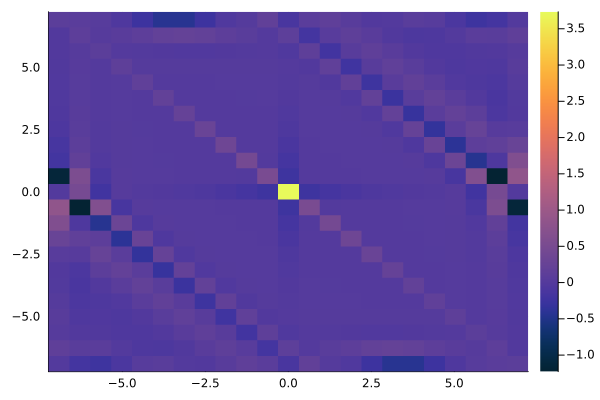

In [22]:
showMeThe(R4_omega)

In [23]:
A7 = c[1, 1]' * c[1, 1]
B7 = c[1, 1]' * c[1, 2]
C7 = c[1, 2]' * c[1, 1]

R7_tau = full_tau((A7,B7,C7), tautau, ham_eb, beta)

101×101 Matrix{Float64}:
 0.277044  4.39301e-25  4.37578e-25  …  -1.75558e-17  -2.20404e-17
 0.23657   0.220673     3.44606e-10      0.0126622     0.0158968
 0.204749  0.188435     0.175773         0.02308       0.0289757
 0.179919  0.163088     0.150094         0.0317901     0.0399108
 0.160616  0.143311     0.129905         0.039106      0.0490955
 0.145629  0.127935     0.114151     …   0.0452427     0.0567998
 0.133992  0.115998     0.101904         0.0503696     0.0632364
 0.124946  0.106728     0.0923957        0.0546319     0.0685875
 0.117905  0.0995233    0.0850122        0.0581576     0.0730138
 0.112415  0.093915     0.0792732        0.0610603     0.076658
 0.108127  0.0895421    0.074806     …   0.0634399     0.0796454
 0.104772  0.0861266    0.0713229        0.0653834     0.0820854
 0.102142  0.083454     0.0686023        0.0669654     0.0840716
 ⋮                                   ⋱                 ⋮
 0.104772  0.083454     0.0664736        0.0634399     0.0820854
 0.1081

In [24]:
@time R7_omega = G_ABC_gl_transform_simplex(A7, B7, C7, H, beta, space, 11, 11)


  1.392479 seconds (2.00 M allocations: 205.703 MiB, 3.69% gc time)


23×23 Matrix{ComplexF64}:
    0.035248+0.000672307im  …    -0.147651-0.0282406im
      0.0175+0.00027892im         0.126597-0.0272446im
 -0.00372074-0.00132812im       -0.0346475-0.0215064im
 -0.00287535-0.0033115im        0.00782905-0.014762im
  -0.0120696-0.00564182im       0.00187712-0.00844914im
  -0.0170735-0.00779944im   …   0.00204988-0.00268459im
  -0.0170494-0.00891109im       0.00194089+0.00288258im
  -0.0105343-0.008461im          0.0019343+0.00874022im
 0.000426823-0.00779756im       0.00206428+0.0153138im
   0.0102363-0.0110317im        0.00269371+0.022679im
   0.0134069-0.0206884im    …   0.00508591+0.0293456im
   0.0734518-0.0297389im         0.0734518+0.0297389im
  0.00508591-0.0293456im         0.0134069+0.0206884im
  0.00269371-0.022679im          0.0102363+0.0110317im
  0.00206428-0.0153138im       0.000426823+0.00779756im
   0.0019343-0.00874022im   …   -0.0105343+0.008461im
  0.00194089-0.00288258im       -0.0170494+0.00891109im
  0.00204988+0.00268459im       -0.0

0.8544207348553545


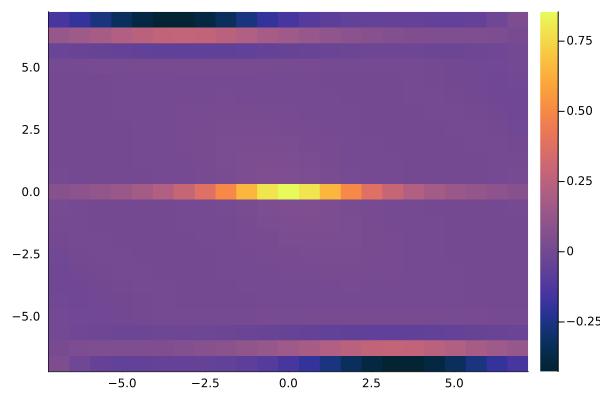

In [25]:
showMeThe(R7_omega)

In [26]:
function isnearzero(val)
    if real(val)+imag(val) > -0.00000001 &&
       real(val)+imag(val) < 0.00000001
        return true
    end
    return false
end

function integralterm1(β, ϵ, ϵ_n, m, s, ω1, ω2, i, j)
    
    term = 0
    #swap omegas \nu = 1 \mu = 2
    enval1 = ϵ[s]-ϵ[m]-im*ω2[j]
    enval2 = ϵ[m]-ϵ_n-im*ω1[i]
    envalm = ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j]
    
    if isnearzero(enval1)
        if isnearzero(enval2)
        #term1
        term = term - (β^2)/2
        else
            #.+
        term = term + (β*ℯ^(-β*enval2)  )/(enval2  )
        term = term + (1*ℯ^(-β*enval2)-1)/(enval2^2) 
        end
    else
        #term2
        #.+-
        td = 1/enval1
        if isnearzero(enval2)
            td = td * - β
        else
            td = td * + (ℯ^(-β*enval2)-1)/(enval2)
        end
        term = term+td
        #term3
        #-
        td = 1/enval1 ###
        if isnearzero(envalm)
            td = td * + β
        else
            td = td * - (ℯ^(-β*envalm)-1)/envalm
        end
        term = term+td
    end 
    return term
end

function G_ABC_n_ord_Lehmann_Bosonic(Ψn::Array{Complex{T},2},ϵ::Array{T,1},ϵ_n::Real, A::Operator,B::Operator,
    C::Operator,n::Array{Complex{T},1}, ω1::Array{T,1},ω2::Array{T,1},β::Real) where T <: Real
    
    val_arr1 = zeros(length(ω1),length(ω2)) .+ 0im
    val_arr2 = zeros(length(ω1),length(ω2)) .+ 0im
    for i in 1:length(ω1), j in 1:length(ω2)
        val_arr1[i,j] = 0 + 0im
        val_arr2[i,j] = 0 + 0im
        for m in 1:length(ϵ), s in 1:length(ϵ)
            
            product = dot(n,A*Ψn[:,m])*dot(Ψn[:,m],B*Ψn[:,s])*dot(Ψn[:,s],C*n)
            ###
            term = integralterm1(β, ϵ, ϵ_n, m, s, ω1, ω2, i, j)

            product = term * product
            val_arr1[i,j] += product

            product = dot(n,B*Ψn[:,m])*dot(Ψn[:,m],A*Ψn[:,s])*dot(Ψn[:,s],C*n)
            ###
            term = integralterm1(β, ϵ, ϵ_n, m, s, ω2, ω1, j, i)

            product = term * product
            val_arr2[i,j] += product

        end
        val_arr1[i,j] *= exp(-ϵ_n*β)
        if wick_parity(A) * wick_parity(B) == 1 #two fermionic Operators
            println("fermionic??")
            val_arr2[i,j] *= -1.0*exp(-ϵ_n*β)
        else
            val_arr2[i,j] *= exp(-ϵ_n*β)
        end
    end
    return val_arr1+val_arr2
end

function G_ABC_Lehmann_Bosonic(A::Operator, B::Operator,C::Operator, τ1::Array{T,1},
    τ2::Array{T,1},H::Operator,β::Real, n_max1::Integer, n_max2::Integer) where T <: Real
    
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2)*π/β
    
    H_eigvec = eigvecs(Array(H)) .+ 0im
    H_eigene = eigvals(Array(H))
    H_eigene = H_eigene .- H_eigene[1] #shift spectrum
    Z = 0
    print(" length ")
    print(length(ω1))
    print(" x ")
    println(length(ω2))
    println(length(H_eigene))
    flush(stdout)
    result = zeros(length(τ1),length(τ2)) .+ 0im
    for i in 1:length(H_eigene)
        print("> eigen value: ")
        println(i)
        flush(stdout)
        if i == 1
            result=G_ABC_n_ord_Lehmann_Bosonic(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],ω1,ω2,β)
        else
            result=result .+ G_ABC_n_ord_Lehmann_Bosonic(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],ω1,ω2,β)
        end
        Z += exp(-β*H_eigene[i])
    end
    result = -1.0 .* result ./ Z
    return result
end

G_ABC_Lehmann_Bosonic (generic function with 1 method)

In [39]:
n_max3 = 5
n_max = n_max3
n3 = collect(-n_max:1:n_max)
n=n3
ω3 = (2n)*π/beta

τ1_arr = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
τ2_arr = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
#for i in 1:100
#    push!(τ1_arr,i/10)
#end

@time lehmann3 = G_ABC_Lehmann_Bosonic(A7,B7,C7,τ1_arr,τ2_arr,H,beta, 0, n_max3)[:,:]
transform3_Lehmann_imag = imag(lehmann3)
transform3_Lehmann_real = real(lehmann3)

#heatmap(ω3, ω3, transform3_Lehmann_real, c = :thermal) 

 length 1 x 11
64
> eigen value: 1
> eigen value: 2
> eigen value: 3
> eigen value: 4
> eigen value: 5
> eigen value: 6
> eigen value: 7
> eigen value: 8
> eigen value: 9
> eigen value: 10
> eigen value: 11
> eigen value: 12
> eigen value: 13
> eigen value: 14
> eigen value: 15
> eigen value: 16
> eigen value: 17
> eigen value: 18
> eigen value: 19
> eigen value: 20
> eigen value: 21
> eigen value: 22
> eigen value: 23
> eigen value: 24
> eigen value: 25
> eigen value: 26
> eigen value: 27
> eigen value: 28
> eigen value: 29
> eigen value: 30
> eigen value: 31
> eigen value: 32
> eigen value: 33
> eigen value: 34
> eigen value: 35
> eigen value: 36
> eigen value: 37
> eigen value: 38
> eigen value: 39
> eigen value: 40
> eigen value: 41
> eigen value: 42
> eigen value: 43
> eigen value: 44
> eigen value: 45
> eigen value: 46
> eigen value: 47
> eigen value: 48
> eigen value: 49
> eigen value: 50
> eigen value: 51
> eigen value: 52
> eigen value: 53
> eigen value: 54
> eigen value: 55
>

1×11 Matrix{Float64}:
 0.285854  0.375945  0.49799  0.648263  …  0.49799  0.375945  0.285854

  1.166920 seconds (283.74 k allocations: 35.479 MiB, 3.16% gc time)


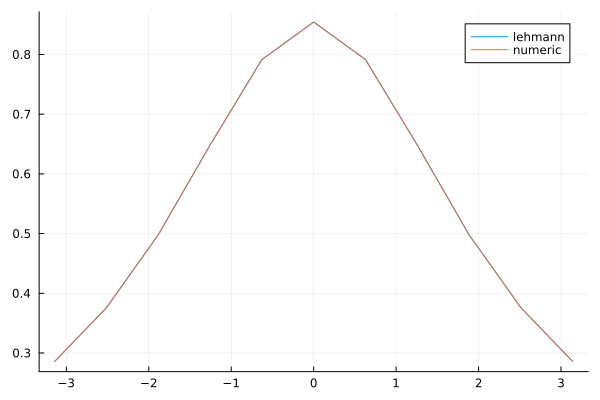

In [37]:
@time R1_omega1 = G_ABC_gl_transform_simplex(A7, B7, C7, H, beta, space, 0, n_max3)

#println(max.(transform3_Lehmann_real))
#println(max.(real(R1_omega1)))
plot(ω3, (transform3_Lehmann_real)', label = "lehmann")
plot!(ω3, real(R1_omega1)', label = "numeric")

#heatmap(ω3, ω3, real(R1_omega1), c = :thermal) 

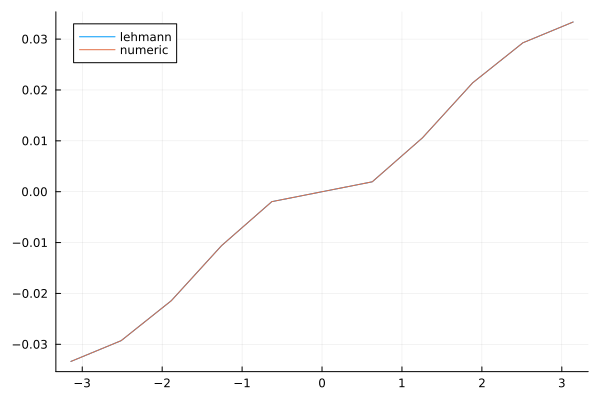

In [38]:
plot(ω3, (transform3_Lehmann_imag)', label = "lehmann")
plot!(ω3, imag(R1_omega1)', label = "numeric")